In [ ]:
import os
import pickle as pkl
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio
import glob
import random
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Set a fixed random seed for reproducibility
random.seed(19)

# Path to save the final DataFrame
output_pkl_path = "../data/data_final.pkl"
with open(output_pkl_path, "rb") as f:
    gdf = pkl.load(f)
    
to_pred_gdf = gdf.loc[gdf['date'] >= pd.to_datetime('2017-01-01 00:00:00')].reset_index(drop=True)
gdf = gdf.loc[gdf['date'] < pd.to_datetime('2017-01-01 00:00:00')].reset_index(drop=True)

In [3]:
# Shuffle tiles and create train, val, and test splits
tiles = gdf['tile_index'].unique().tolist()
random.shuffle(tiles)

# Define split ratios
train_ratio = 0.6
val_ratio = 0.2

# Calculate split indices
train_split_index = int(train_ratio * len(tiles))
val_split_index = int((train_ratio + val_ratio) * len(tiles))

# Split tiles into train, validation, and test sets
train_tiles = tiles[:train_split_index]
val_tiles = tiles[train_split_index:val_split_index]
test_tiles = tiles[val_split_index:]

# Filter DataFrame by tile indices for each set
train_gdf = gdf.loc[gdf['tile_index'].isin(train_tiles)]
val_gdf = gdf.loc[gdf['tile_index'].isin(val_tiles)]
test_gdf = gdf.loc[gdf['tile_index'].isin(test_tiles)]

# Define feature and target columns
X_cols = [col for col in gdf.columns if col.startswith('feature')]
y_col = 'urban_imperviousness'

# Prepare data arrays for train, validation, and test
X_train = train_gdf[X_cols]
y_train = np.stack(train_gdf[y_col].values).reshape(-1, 3, 3)

X_val = val_gdf[X_cols]
y_val = np.stack(val_gdf[y_col].values).reshape(-1, 3, 3)

X_test = test_gdf[X_cols]
y_test = np.stack(test_gdf[y_col].values).reshape(-1, 3, 3)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 9), dtype=torch.float32)  # Flattened 3x3 grids

X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.reshape(-1, 9), dtype=torch.float32)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.reshape(-1, 9), dtype=torch.float32)

In [4]:
print(X_train.values.shape)
print(y_train.shape)

(10716, 768)
(10716, 3, 3)


In [5]:
# Baseline Model

# Calculate the mean urban imperviousness for each cell in the 3x3 grid across the training set
baseline_prediction = np.mean(y_train, axis=0)
print("Baseline prediction (3x3 grid):\n", baseline_prediction)

# Flatten the true and predicted 3x3 grids to apply the metrics for the test set
y_test_flat = y_test.reshape(-1, 9)  # Flatten each 3x3 grid in y_test to a 9-element vector

# Repeat the baseline prediction for each sample in y_test for comparison
baseline_pred = np.tile(baseline_prediction.flatten(), (y_test_flat.shape[0], 1))

# Calculate baseline metrics on the test set
mse_baseline = mean_squared_error(y_test_flat, baseline_pred)
mae_baseline = mean_absolute_error(y_test_flat, baseline_pred)

print(f"Baseline MSE on Test Set: {mse_baseline}")
print(f"Baseline MAE on Test Set: {mae_baseline}")

Baseline prediction (3x3 grid):
 [[0.0311702  0.03183376 0.03064398]
 [0.03174684 0.03158727 0.03139694]
 [0.03146682 0.03078669 0.03192314]]
Baseline MSE on Test Set: 0.005950284656137228
Baseline MAE on Test Set: 0.040894515812397


In [6]:
def train_model(
    model, 
    X_train_tensor, 
    y_train_tensor, 
    X_val_tensor=None, 
    y_val_tensor=None, 
    epochs=100, 
    criterion=nn.MSELoss(), 
    optimizer=None, 
    lr=0.001, 
    batch_size=32, 
    verbose=True,
    use_batch_processing=True, 
    early_stopping=False,  # New argument to enable early stopping
    patience=10,  # Number of epochs with no improvement before stopping
    min_delta=0.0  # Minimum improvement to reset patience
):
    # Set up optimizer if none is provided
    if optimizer is None:
        optimizer = optim.Adam(model.parameters(), lr=lr)

    # Create DataLoader for batch processing if enabled
    if use_batch_processing:
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    else:
        # No batch processing; use the entire dataset in each pass
        train_loader = [(X_train_tensor, y_train_tensor)]

    # Early stopping initialization
    best_loss = float('inf')
    patience_counter = 0

    # Training loop
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        total_loss = 0
        for X_batch, y_batch in train_loader:
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Calculate average training loss
        avg_loss = total_loss / len(train_loader)

        # Print epoch loss every 10 epochs if verbose is enabled
        if verbose and (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Training Loss: {avg_loss:.4f}')

        # Early stopping check (only if validation data is provided)
        if early_stopping and X_val_tensor is not None and y_val_tensor is not None:
            model.eval()  # Set model to evaluation mode
            with torch.no_grad():
                val_outputs = model(X_val_tensor)
                val_loss = criterion(val_outputs, y_val_tensor).item()

            if verbose and (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch + 1}/{epochs}], Validation Loss: {val_loss:.4f}')

            # Check for improvement
            if val_loss < best_loss - min_delta:
                best_loss = val_loss
                patience_counter = 0  # Reset patience if there is improvement
            else:
                patience_counter += 1  # Increment patience if no improvement

            # Stop training if patience is exceeded
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1} with Validation Loss: {best_loss:.4f}")
                break

    return model

In [7]:
# Simple fully connected (dense) neural network 

class SimpleNN(nn.Module):
    def __init__(self, input_size=768, output_size=9, hidden_units=128):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_units)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_units, output_size)  # Output layer matches the size of the 3x3 grid
    
    def forward(self, x):
        # Apply logit transformation at the input layer
        x = torch.clamp(x, min=1e-6, max=1 - 1e-6) # Avoid 0 and 1 to prevent logit issues
        x = torch.log(x / (1 - x))
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)  # Apply sigmoid to get output back in [0, 1] range
        return x

# Train the model using the train_model function
simple_nn_model = SimpleNN(input_size=768, output_size=9, hidden_units=128)
trained_simple_nn_model = train_model(
    model=simple_nn_model,
    X_train_tensor=X_train_tensor,
    y_train_tensor=y_train_tensor,
    X_val_tensor=X_val_tensor,  # Validation data
    y_val_tensor=y_val_tensor,  # Validation target
    epochs=100,
    lr=0.0005,
    batch_size=64,
    verbose=True,
    use_batch_processing=True,
    early_stopping=True,  # Enable early stopping
    patience=10,  # Wait for 10 epochs without improvement
    min_delta=0.001  # Minimum loss improvement to reset patience
)
# Prediction on test data
with torch.no_grad():
    snn_pred = trained_simple_nn_model(X_test_tensor)

# Calculate metrics
mse_snn = nn.MSELoss()(snn_pred, y_test_tensor).item()
mae_snn = nn.L1Loss()(snn_pred, y_test_tensor).item()

print(f"SimpleNN MSE on Test Set: {mse_snn}")
print(f"SimpleNN MAE on Test Set: {mae_snn}")

Epoch [10/100], Training Loss: 0.0063
Epoch [10/100], Validation Loss: 0.0068
Early stopping at epoch 11 with Validation Loss: 0.0070
SimpleNN MSE on Test Set: 0.006989387329667807
SimpleNN MAE on Test Set: 0.032247379422187805


In [26]:
# Deep Fully Connected Neural Network

class DeepNN(nn.Module):
    def __init__(self, input_size=768, output_size=9, hidden_units=128):
        super(DeepNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_units)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_units, hidden_units)
        self.fc3 = nn.Linear(hidden_units, output_size)  # Output layer matches 3x3 grid size

    def forward(self, x):
        # Apply logit transformation at the input layer
        x = torch.clamp(x, min=1e-6, max=1 - 1e-6) # Avoid 0 and 1 to prevent logit issues
        x = torch.log(x / (1 - x))
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = torch.sigmoid(x) # Apply sigmoid to get output back in [0, 1] range
        return x

# Train the model using the train_model function
deep_nn_model = DeepNN(input_size=768, output_size=9, hidden_units=128)
trained_deep_nn_model = train_model(
    model=deep_nn_model,
    X_train_tensor=X_train_tensor,
    y_train_tensor=y_train_tensor,
    X_val_tensor=X_val_tensor,  
    y_val_tensor=y_val_tensor, 
    epochs=100,
    lr=0.0005,
    batch_size=64,
    verbose=True,
    use_batch_processing=True,
    early_stopping=True, 
    patience=30, 
    min_delta=0.001  
)

# Prediction on test data
with torch.no_grad():
    dnn_pred = trained_deep_nn_model(X_test_tensor)

# Calculate metrics
mse_dnn = nn.MSELoss()(dnn_pred, y_test_tensor).item()
mae_dnn = nn.L1Loss()(dnn_pred, y_test_tensor).item()

print(f"DeepNN MSE on Test Set: {mse_dnn}")
print(f"DeepNN MAE on Test Set: {mae_dnn}")


Epoch [10/100], Training Loss: 0.0018
Epoch [10/100], Validation Loss: 0.0032
Epoch [20/100], Training Loss: 0.0013
Epoch [20/100], Validation Loss: 0.0034
Epoch [30/100], Training Loss: 0.0010
Epoch [30/100], Validation Loss: 0.0034
Early stopping at epoch 34 with Validation Loss: 0.0037
DeepNN MSE on Test Set: 0.003166444832459092
DeepNN MAE on Test Set: 0.02785145491361618


In [24]:
class CNNModel(nn.Module):
    def __init__(self, input_size=768, output_size=9, hidden_units=128):
        super(CNNModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_units)
        self.relu = nn.ReLU()
        self.hidden_units = hidden_units  # Store hidden_units as a class attribute
        self.output_size = output_size  # Store output_size as a class attribute

        # Define a Conv1d layer
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1)
        
        # Second fully connected layer to project to the output size
        conv_out_size = (hidden_units - 3 + 1) * 16  # Calculating the output size of conv layer
        self.fc2 = nn.Linear(conv_out_size, output_size)

    def forward(self, x):
        # Apply logit transformation at the input layer
        x = torch.clamp(x, min=1e-6, max=1 - 1e-6) # Avoid 0 and 1 to prevent logit issues
        x = torch.log(x / (1 - x))
        # Fully connected layer followed by ReLU activation
        x = self.fc1(x)
        x = self.relu(x)
        # Reshape to match Conv1d input shape (batch_size, channels, sequence_length)
        x = x.view(-1, 1, self.hidden_units)
        # Convolutional layer followed by flattening
        x = self.conv1(x)
        x = x.view(x.size(0), -1)  # Flatten before passing to the output layer
        # Fully connected and sigmoid activation for output
        x = self.fc2(x)
        x = torch.sigmoid(x) # Apply sigmoid to get output back in [0, 1] range
        return x


# Train the model using the train_model function
cnn_model = CNNModel(input_size=768, output_size=9, hidden_units=128)
trained_cnn_model = train_model(
    model=cnn_model,
    X_train_tensor=X_train_tensor,
    y_train_tensor=y_train_tensor,
    X_val_tensor=X_val_tensor, 
    y_val_tensor=y_val_tensor, 
    epochs=100,
    lr=0.0005,
    verbose=True,
    use_batch_processing=False,
    early_stopping=True, 
    patience=25, 
    min_delta=0.001
)


# Prediction on test data
with torch.no_grad():
    cnn_pred = trained_cnn_model(X_test_tensor)

# Calculate metrics
mse_cnn = nn.MSELoss()(cnn_pred, y_test_tensor).item()
mae_cnn = nn.L1Loss()(cnn_pred, y_test_tensor).item()

print(f"CNN MSE on Test Set: {mse_cnn}")
print(f"CNN MAE on Test Set: {mae_cnn}")


Epoch [10/100], Training Loss: 0.0063
Epoch [10/100], Validation Loss: 0.0070
Epoch [20/100], Training Loss: 0.0063
Epoch [20/100], Validation Loss: 0.0070
Early stopping at epoch 27 with Validation Loss: 0.0065
CNN MSE on Test Set: 0.0069894203916192055
CNN MAE on Test Set: 0.03224740922451019


In [10]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=768, output_size=9, hidden_units=128, lstm_layers=1):
        super(LSTMModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_units)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size=hidden_units, hidden_size=hidden_units, num_layers=lstm_layers, batch_first=True)
        self.fc2 = nn.Linear(hidden_units, output_size)

    def forward(self, x):
        # Apply logit transformation at the input layer
        x = torch.clamp(x, min=1e-6, max=1 - 1e-6) # Avoid 0 and 1 to prevent logit issues
        x = torch.log(x / (1 - x))
        # First fully connected layer
        x = self.fc1(x)
        x = self.relu(x)
        # Reshape for LSTM: (batch_size, sequence_length, input_size)
        x = x.unsqueeze(1)  # Adding a sequence dimension, shape becomes (batch_size, 1, hidden_units)
        # LSTM layer
        lstm_out, _ = self.lstm(x)
        # Take the output of the last LSTM cell
        x = lstm_out[:, -1, :]
        # Final fully connected layer and sigmoid activation
        x = self.fc2(x)
        x = torch.sigmoid(x) # Apply sigmoid to get output back in [0, 1] range
        return x

# Initialize the LSTM model
lstm_model = LSTMModel(input_size=768, output_size=9, hidden_units=128, lstm_layers=1)

# Train the model using the `train_model` function
trained_lstm_model = train_model(
    model=lstm_model,
    X_train_tensor=X_train_tensor,
    y_train_tensor=y_train_tensor,
    X_val_tensor=X_val_tensor,  # Validation data
    y_val_tensor=y_val_tensor,  # Validation target
    epochs=100,
    lr=0.0005,
    batch_size=64,
    verbose=True,
    use_batch_processing=True,
    early_stopping=True, 
    patience=20, 
    min_delta=0.001  
)


# Prediction on test data
with torch.no_grad():
    lstm_pred = trained_lstm_model(X_test_tensor)

# Calculate metrics
mse_lstm = nn.MSELoss()(lstm_pred, y_test_tensor).item()
mae_lstm = nn.L1Loss()(lstm_pred, y_test_tensor).item()

print(f"LSTM MSE on Test Set: {mse_lstm}")
print(f"LSTM MAE on Test Set: {mae_lstm}")


Epoch [10/100], Training Loss: 0.0026
Epoch [10/100], Validation Loss: 0.0032
Epoch [20/100], Training Loss: 0.0019
Epoch [20/100], Validation Loss: 0.0033
Epoch [30/100], Training Loss: 0.0014
Epoch [30/100], Validation Loss: 0.0034
Early stopping at epoch 30 with Validation Loss: 0.0032
LSTM MSE on Test Set: 0.0031054599676281214
LSTM MAE on Test Set: 0.027525505051016808


In [27]:
# Calculate RMSE for each model
rmse_baseline = np.sqrt(mse_baseline)
rmse_snn = np.sqrt(mse_snn)
rmse_dnn = np.sqrt(mse_dnn)
rmse_cnn = np.sqrt(mse_cnn)
rmse_lstm = np.sqrt(mse_lstm)

# Create a summary table
metrics_summary = pd.DataFrame({
    'Model': ['Baseline', 'SimpleNN', 'DeepNN', 'CNN', 'LSTM'],
    'MSE': [mse_baseline, mse_snn, mse_dnn, mse_cnn, mse_lstm],
    'RMSE': [rmse_baseline, rmse_snn, rmse_dnn, rmse_cnn, rmse_lstm],
    'MAE': [mae_baseline, mae_snn, mae_dnn, mae_cnn, mae_lstm]
})
print(metrics_summary)


      Model       MSE      RMSE       MAE
0  Baseline  0.005950  0.077138  0.040895
1  SimpleNN  0.006989  0.083603  0.032247
2    DeepNN  0.003166  0.056271  0.027851
3       CNN  0.006989  0.083603  0.032247
4      LSTM  0.003105  0.055727  0.027526


<module 'matplotlib.pyplot' from 'c:\\Users\\btripp\\urban-clay\\env\\Lib\\site-packages\\matplotlib\\pyplot.py'>

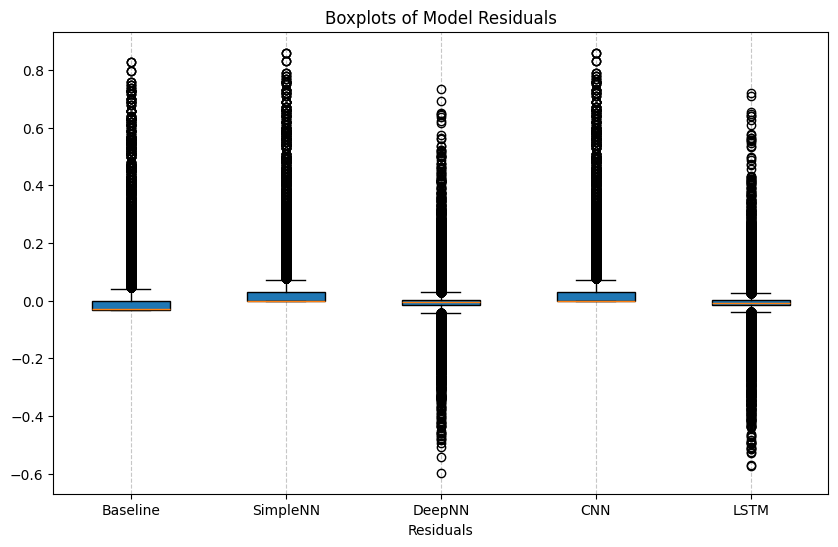

In [28]:
# Flatten predictions and ground truth for residual analysis
def res_plot(y_tensor, yhat_tensors, labels, title="", figsize=(10, 5)):
    # Initialize plot with the specified figure size
    plt.figure(figsize=figsize)
    
    y_flat = y_tensor.numpy().reshape(-1)  # Flatten ground truth
    residuals_list = []  # Collect residuals for each model
    
    # Calculate residuals for each model's predictions
    for yhat_tensor in yhat_tensors:
        if isinstance(yhat_tensor, torch.Tensor):
            yhat_flat = yhat_tensor.numpy().reshape(-1)
        else:
            yhat_flat = yhat_tensor.reshape(-1)
        residuals = y_flat - yhat_flat
        residuals_list.append(residuals)
    
    # Create box plots for residuals
    plt.boxplot(residuals_list, tick_labels=labels, vert=True, patch_artist=True)
    plt.xlabel('Residuals')
    plt.title(title)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    return plt

res_plot(y_test_tensor, 
         [baseline_pred, snn_pred, dnn_pred, cnn_pred, lstm_pred], 
         ["Baseline", "SimpleNN", "DeepNN", "CNN", "LSTM"], 
         "Boxplots of Model Residuals", (10, 6))

In [29]:
prediction_stats = pd.DataFrame({
    "Actual": pd.Series(y_test.flatten()).describe(),
    "Baseline": pd.Series(baseline_pred.flatten()).describe(),
    "SimpleNN": pd.Series(snn_pred.numpy().flatten()).describe(),
    "DeepNN": pd.Series(dnn_pred.numpy().flatten()).describe(),
    "CNN": pd.Series(cnn_pred.numpy().flatten()).describe(),
    "LSTM": pd.Series(lstm_pred.numpy().flatten()).describe()
})
print(prediction_stats)

             Actual      Baseline      SimpleNN        DeepNN           CNN  \
count  32157.000000  32157.000000  3.215700e+04  32157.000000  3.215700e+04   
mean       0.032247      0.031395  1.982170e-07      0.037187  8.527194e-09   
std        0.077134      0.000425  7.362613e-07      0.070759  2.845097e-08   
min        0.000000      0.030644  7.180152e-16      0.000144  1.425238e-16   
25%        0.000000      0.031170  1.916346e-13      0.005535  1.502081e-14   
50%        0.000000      0.031467  1.268171e-11      0.013676  1.195147e-10   
75%        0.030000      0.031747  1.618316e-07      0.035137  6.415345e-10   
max        0.860000      0.031923  4.283137e-05      0.863463  5.566307e-07   

               LSTM  
count  32157.000000  
mean       0.036645  
std        0.073354  
min        0.003604  
25%        0.008284  
50%        0.014108  
75%        0.030976  
max        0.725279  


In [31]:
# Save Models
models = {
    "SimpleNN": trained_simple_nn_model,
    "DeepNN": trained_deep_nn_model,
    "CNN": trained_cnn_model,
    "LSTM": trained_lstm_model
}

for mname in models.keys():
    with open(os.path.join('../artifacts/models', mname+'.pkl'), 'wb') as f:
        pkl.dump(models[mname], f)

In [51]:
to_pred_test = to_pred_gdf.loc[to_pred_gdf.date == pd.Timestamp('2017-08-19 15:48:59')].reset_index(drop=True)
to_pred_test_X = torch.tensor(to_pred_test[X_cols].values, dtype=torch.float32)
with torch.no_grad():
    pred = trained_lstm_model(to_pred_test_X).reshape(-1, 3, 3).numpy()

In [47]:
pred.shape

(5954, 3, 3)

In [ ]:
def array_to_raster(array, crs, xmin, ymin, xmax, ymax, output_path):
    """Convert a numpy array to a raster file on disk."""
    
    # Define the transform based on bounds and array dimensions
    transform = rasterio.transform.from_bounds(xmin, ymin, xmax, ymax, array.shape[1], array.shape[0])

    # Define the profile for the output raster
    profile = {
        'driver': 'GTiff',
        'height': array.shape[0],
        'width': array.shape[1],
        'count': 1,
        'dtype': array.dtype,
        'crs': crs,
        'transform': transform,
    }

    # Save raster directly to disk
    with rasterio.open(output_path, "w", **profile) as dataset:
        dataset.write(array, 1)  # Write the array to the first band
    # print(f"Raster saved to {output_path}")

def generate_prediction_rasters(predictions, gdf, crs, output_dir):
    """
    Generate and save prediction rasters for each tile in a specific date.
    
    Parameters:
    - predictions (array): Predicted arrays for each tile.
    - gdf (GeoDataFrame): GeoDataFrame with tile bounds and other metadata.
    - crs: Coordinate reference system for the output raster.
    - output_dir (str): Directory to save the rasters.
    """
    for i, pred in enumerate(predictions):
        # Define bounds for this tile from the gdf
        xmin, ymin, xmax, ymax = gdf.iloc[i][['min_x', 'min_y', 'max_x', 'max_y']]
        
        # Define the output path for the tile
        raster_path = os.path.join(output_dir, f"prediction_tile_{i}.tif")
        
        # Convert prediction array to a raster and save it directly to disk
        array_to_raster(pred, crs, xmin, ymin, xmax, ymax, raster_path)


def merge_subdivided_tiles(input_tile_dir, output_merged_file):
    """
    Merge all subdivided tiles in the input directory into a single raster file.

    Parameters:
    - input_tile_dir (str): The directory containing the subdivided tiles (.tif files).
    - output_merged_file (str): The path to save the merged raster file.
    """
    # Collect all the .tif files in the input directory
    tile_files = glob.glob(os.path.join(input_tile_dir, "*.tif"))
    
    if not tile_files:
        print(f"No .tif files found in {input_tile_dir}")
        return
    
    # List to hold the opened rasterio datasets
    src_files_to_merge = []

    for tif in tile_files:
        src = rasterio.open(tif)
        src_files_to_merge.append(src)

    # Perform the merge
    mosaic, out_trans = rasterio.warp.merge(src_files_to_merge)

    # Get metadata from one of the source files
    out_meta = src_files_to_merge[0].meta.copy()

    # Update the metadata to reflect the new dimensions, transform, and CRS
    out_meta.update({
        "driver": "GTiff",
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": out_trans,
        "count": mosaic.shape[0],  # Update count to match the number of bands in the mosaic
        "dtype": mosaic.dtype  # Make sure the data type is set properly
    })

    # Write the merged raster to disk, ensuring all bands are written correctly
    with rasterio.open(output_merged_file, "w", **out_meta) as dest:
        for i in range(1, mosaic.shape[0] + 1):
            dest.write(mosaic[i - 1], i)

    # Close the opened files
    for src in src_files_to_merge:
        src.close()

    print(f"Merged raster saved to {output_merged_file}")



# Generate predictions and save as rasters
output_dir = "../data/prediction_rasters_aug_2017"
os.makedirs(output_dir, exist_ok=True)

generate_prediction_rasters(pred, to_pred_gdf, to_pred_gdf.crs, output_dir)

# Define your parameters
output_merged_file = "../data/merged_urban_raster_aug_2017_pred.tif"

if not os.path.exists(output_merged_file):
    # Call the function to merge the subdivided tiles
    merge_subdivided_tiles(output_dir, output_merged_file)

In [ ]:

# Define a reversed colormap based on inferno and set NaN values to white
cmap = plt.cm.inferno.reversed()
cmap.set_bad(color='#fefefe')  # Set NaN values to white

# Path to the merged raster file
merged_raster_path = "../data/merged_urban_raster_aug_2017_pred.tif"

# Read the merged raster and plot it
with rasterio.open(merged_raster_path) as src:
    # Read the raster data
    raster_data = src.read(1)  # Assuming a single-band raster
    
    # Mask NaN values (if not already masked)
    raster_data = np.ma.masked_where(raster_data == src.nodata, raster_data)
    
    # Plot the raster with the custom colormap
    plt.figure(figsize=(5, 5))
    plt.imshow(raster_data, cmap=cmap)
    plt.colorbar(label='Predicted Value')
    plt.title('Merged Urban Imperviousness Prediction')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(False)  # Optionally disable gridlines for a cleaner look
    plt.show()